## Load Package

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from datetime import datetime, timedelta
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

## Set Parameter

In [2]:
# set parameters
stock_start_date = "2015-01-01"
stock_end_date = "2019-01-01"
VaR_q = 0.05

## Download Portfolio Data

In [3]:
# download stock data
ticker = ['TSLA']
start_date = stock_start_date
end_date = stock_end_date

top_price = yf.download(ticker,
                        start = start_date,
                        end = end_date)


[*********************100%***********************]  1 of 1 completed


In [4]:
# choose the adjust price to analyze
#top_price = top_price[["Adj Close", "Volume"]]
top_price = top_price["Adj Close"]

In [5]:
top_price

Date
2015-01-02    14.620667
2015-01-05    14.006000
2015-01-06    14.085333
2015-01-07    14.063333
2015-01-08    14.041333
                ...    
2018-12-24    19.692667
2018-12-26    21.739332
2018-12-27    21.075333
2018-12-28    22.257999
2018-12-31    22.186666
Name: Adj Close, Length: 1006, dtype: float64

In [6]:
# calculate daily log return
# volume = top_price.iloc[1:, 1]
top_ret = np.log(top_price) - np.log(top_price.shift(1))

top_ret.dropna(axis = 0, inplace = True)
# top_ret['Volume'] = volume

In [7]:
top_ret

Date
2015-01-05   -0.042950
2015-01-06    0.005648
2015-01-07   -0.001563
2015-01-08   -0.001566
2015-01-09   -0.018981
                ...   
2018-12-24   -0.079305
2018-12-26    0.098877
2018-12-27   -0.031020
2018-12-28    0.054598
2018-12-31   -0.003210
Name: Adj Close, Length: 1005, dtype: float64

## Historical Rolling window Approach To Calculate VaR

### Define A Function

In [8]:
# define a function to get 95%-VaR for equal weighted portfolio (i.e. invest 100 to each stock)
def get_VaR(ret, q):
    T = 754
    num_return = len(ret)
    #num_asset = len(ret.columns)
    # num_asset = 1
    #investment_money = 100*num_asset
    investment_money = 1
    VaR_hist = np.zeros(num_return - T)
    actual_ret = np.zeros(num_return - T)
    
    for t in range(T, num_return):
        #w = 1/num_asset
        
        #scenario_port_ret_t = ret.iloc[t-T:t, :] * w
        scenario_port_ret_t = ret[t-T:t]
        #scenario_port_ret_t = scenario_port_ret_t.sum(axis = 1)
        scenario_port_val_t = investment_money * scenario_port_ret_t
        VaR_hist[t-T] = -np.quantile(scenario_port_val_t, q = q)
        
        #actual_ret[t-T] = investment_money*((ret.iloc[t,:] * w).sum())
        actual_ret[t-T] = investment_money * ret[t]
        
    return VaR_hist, actual_ret

In [9]:
VaR_hist_top, actual_ret_top = get_VaR(top_ret, VaR_q)

In [10]:
VaR_hist_top.shape

(251,)

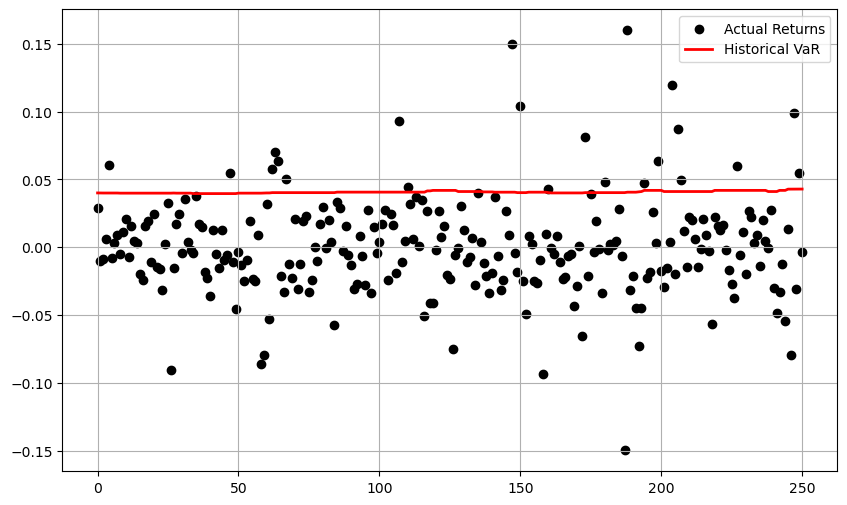

In [11]:
plt.figure(figsize=(10,6))
plt.scatter(range(len(actual_ret_top)) , actual_ret_top , 
            color='k',
            label = "Actual Returns")
plt.plot(range(len(VaR_hist_top)) , VaR_hist_top , 
         color='r', 
         linewidth=2,
         label = "Historical VaR")

plt.legend()
plt.grid()
plt.show()

### Out-of-sample observed Proportion of exceptions

In [12]:
# Empirically loss exceed our 95% VaR some of the time:
np.mean(-actual_ret_top > VaR_hist_top)

0.0796812749003984

### Out-of-sample VaR 

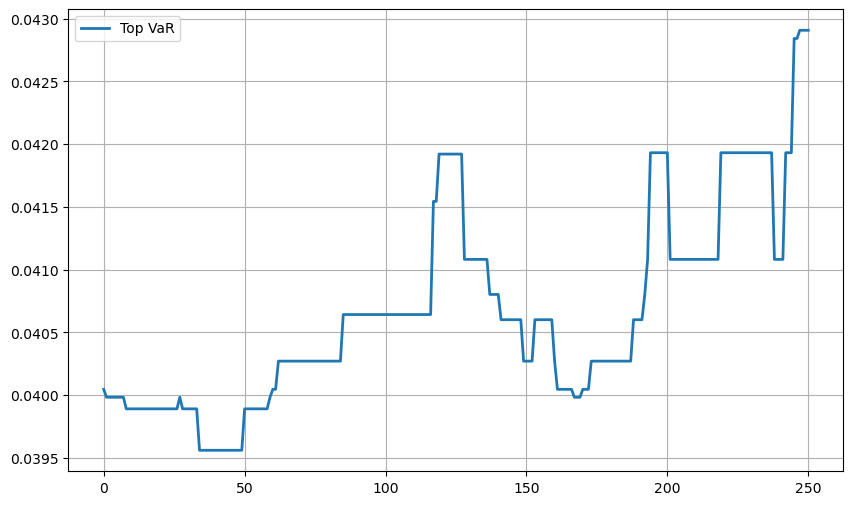

In [13]:
plt.figure(figsize=(10,6))
plt.plot(range(len(VaR_hist_top)), VaR_hist_top,
         label = "Top VaR",
         linewidth=2)

plt.legend()
plt.grid()
plt.show()

## Financial Time Series Quantile Regression Neural Network

### Download Data

In [14]:
ticker = ['TSLA']
start_date = datetime.strptime(stock_start_date, "%Y-%m-%d") - timedelta(days=22)
end_date = stock_end_date

top_price = yf.download(ticker,
                        start = start_date,
                        end = end_date)

[*********************100%***********************]  1 of 1 completed


In [15]:
top_ret = np.log(top_price['Adj Close']) - np.log(top_price['Adj Close'].shift(1))
top_volume_ret = np.log(top_price['Volume']) - np.log(top_price['Volume'].shift(1))
sd_3 = top_ret.rolling(window=3).std()
sd_7 = top_ret.rolling(window=7).std()
sd_15 = top_ret.rolling(window=15).std()

In [16]:
df = pd.DataFrame({
    'returns': top_ret,
    'returns_1': top_ret.shift(1),
    'returns_2': top_ret.shift(2),
    'returns_3': top_ret.shift(3),
    'vol_1': top_volume_ret.shift(1),
    'vol_2': top_volume_ret.shift(2),
    'vol_3': top_volume_ret.shift(3),
    'sd_3': sd_3.shift(1),
    'sd_7': sd_7.shift(1),
    'sd_15': sd_15.shift(1),
})

df = df.dropna()
df_train = df.loc['2015-01-01':'2017-12-31']
df_test = df.loc['2018-01-01':'2019-01-01']
# Visualizza il DataFrame risultante
print(df_train)

             returns  returns_1  returns_2  returns_3     vol_1     vol_2  \
Date                                                                        
2015-01-05 -0.042950  -0.014036   0.000810  -0.015538  0.729350 -0.233992   
2015-01-06  0.005648  -0.042950  -0.014036   0.000810  0.119377  0.729350   
2015-01-07 -0.001563   0.005648  -0.042950  -0.014036  0.153935  0.119377   
2015-01-08 -0.001566  -0.001563   0.005648  -0.042950 -0.746461  0.153935   
2015-01-09 -0.018981  -0.001566  -0.001563   0.005648  0.148175 -0.746461   
...              ...        ...        ...        ...       ...       ...   
2017-12-22 -0.019670   0.008113  -0.006424  -0.023196 -0.305794 -0.136563   
2017-12-26 -0.024624  -0.019670   0.008113  -0.006424 -0.039396 -0.305794   
2017-12-27 -0.017968  -0.024624  -0.019670   0.008113  0.037844 -0.039396   
2017-12-28  0.011866  -0.017968  -0.024624  -0.019670  0.073450  0.037844   
2017-12-29 -0.012797   0.011866  -0.017968  -0.024624 -0.087735  0.073450   

### P, Q, Z, K : Model complexity 
#### this task was splitted and runned (see TSLA_2 and TSLA_3): it took a total of almost 25 hours

In [ ]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

results = []

for ret in range(1,2):
    for vol in range(1,4):
        for sd in range(1,4):
            for nodes in range(1,4):
                loss = []
                for nseed in range(1, 101):
                    seed = nseed
                    random.seed(seed)
                    np.random.seed(seed)
                    tf.random.set_seed(seed)

                    q = 0.05

                    # build neural network 
                    nn_reg = keras.Sequential()
                    nn_reg.add(keras.layers.Dense(nodes, 
                                                    input_dim = ret+vol+sd,
                                                    activation='sigmoid')) 
                    nn_reg.add(keras.layers.Dense(1, activation='linear')) 
                    #nn_reg.summary()
                        
                    # compile neural network
                    nn_reg.compile(optimizer = keras.optimizers.Adam(),
                                    loss=quantile_loss(q))   
                            
                    x_t = df_train.iloc[:, list(range(1, ret+1)) + list(range(4, vol+4)) + list(range(7, sd+7))].to_numpy()
                    y_t = df_train.iloc[:, 0].to_numpy()
                            
                    model = nn_reg.fit(x_t, 
                                    y_t,
                                    epochs = 100,
                                    verbose = 0)
                    
                    loss.append(model.history['loss'][-1])
                results.append([str([ret, vol, sd, nodes]), np.mean(loss), np.std(loss)/100, 
                            np.mean(loss) + 2 * np.std(loss)/100, np.mean(loss) - 2 * np.std(loss)/100, ((ret+vol+sd+1)*nodes+1)/754])

In [ ]:
results_1 = pd.DataFrame(results, columns=['p, q, z, k', 'Loss', 'SE', 'Upper', 'Lower', 'Penalty'])
results_1.to_csv('results_1.csv', index=True)

In [ ]:
results_1

### Results for p, q, z and K choice

In [17]:
results_1 = pd.read_csv('results_1.csv', index_col=0)
results_2 = pd.read_csv('results_2.csv', index_col=0)
results_3 = pd.read_csv('results_3.csv', index_col=0)
results = pd.concat([results_1, results_2, results_3])
results['AIC'] = np.log(results['Loss']) + results['Penalty']
results = results.sort_values(by='AIC', ascending=True)
pd.set_option('display.max_rows', len(results))
results

,"p, q, z, k",Loss,SE,Upper,Lower,Penalty,AIC
19,"[1, 3, 1, 2]",0.002719,3.745183e-07,0.002719,0.002718,0.017241,-5.890389
22,"[1, 3, 2, 2]",0.002714,3.304500e-07,0.002714,0.002713,0.019894,-5.889620
25,"[1, 3, 3, 2]",0.002712,2.962367e-07,0.002712,0.002711,0.022546,-5.887650
22,"[2, 3, 2, 2]",0.002712,3.474228e-07,0.002712,0.002711,0.022546,-5.887633
19,"[2, 3, 1, 2]",0.002720,3.994752e-07,0.002720,0.002719,0.019894,-5.887388
19,"[3, 3, 1, 2]",0.002715,3.864290e-07,0.002716,0.002714,0.022546,-5.886499
24,"[1, 3, 3, 1]",0.002746,4.581506e-07,0.002747,0.002745,0.011936,-5.885813
24,"[2, 3, 3, 1]",0.002742,4.204681e-07,0.002743,0.002741,0.013263,-5.885792
21,"[2, 3, 2, 1]",0.002746,4.693734e-07,0.002747,0.002745,0.011936,-5.885667
21,"[1, 3, 2, 1]",0.002750,5.158366e-07,0.002751,0.002749,0.010610,-5.885468


### HYPERPARAMETERS TUNING
#### this task was splitted and runned (see TSLA_2 and TSLA_3): it took a total of almost 40 hours

In [20]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.0001]:
     for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10]:
          for drop in [0.1, 0.2]:
            loss = []
            y_pred = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear')) 
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]  
                y_pred.append(predictions)               
                loss.append(model.history['val_loss'][-1])

            y_pred = [sum(elements) / len(y_pred) for elements in zip(*y_pred)]     
            exceptions = np.mean(y_val < y_pred)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 1, 2]), np.mean(loss), exceptions])              

C:\Users\lausiell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019E611B5120> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━

In [21]:
results_4 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss', 'exceptions'])
results_4.to_csv('results_4.csv', index=True)

In [17]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.001]:
     for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10]:
          for drop in [0.1, 0.2]:
            loss = []
            y_pred = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear')) 
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]  
                y_pred.append(predictions)               
                loss.append(model.history['val_loss'][-1])

            y_pred = [sum(elements) / len(y_pred) for elements in zip(*y_pred)]     
            exceptions = np.mean(y_val < y_pred)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 1, 2]), np.mean(loss), exceptions])      

5/5 [==============================] - 0s 0s/step


In [18]:
results_5 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss', 'exceptions'])
results_5.to_csv('results_5.csv', index=True)

In [19]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.01, 0.1]:
     for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10]:
          for drop in [0.1, 0.2]:
            loss = []
            y_pred = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear')) 
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]  
                y_pred.append(predictions)               
                loss.append(model.history['val_loss'][-1])

            y_pred = [sum(elements) / len(y_pred) for elements in zip(*y_pred)]     
            exceptions = np.mean(y_val < y_pred)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 1, 2]), np.mean(loss), exceptions])      

5/5 [==============================] - 0s 0s/step


In [21]:
results_6 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss', 'exceptions'])
results_6.to_csv('results_6.csv', index=True)

In [18]:
results_4 = pd.read_csv('results_4.csv', index_col=0)
results_5 = pd.read_csv('results_5.csv', index_col=0)
results_6 = pd.read_csv('results_6.csv', index_col=0)
results = pd.concat([results_4, results_5, results_6])
results = results.sort_values(by='exceptions', ascending=False)
pd.set_option('display.max_rows', len(results))
results

,"lr, lambda, dropout","p, q, z, k",Validation Loss,exceptions
2,"[0.0001, 0.001, 0.1]","[1, 3, 1, 2]",0.084415,0.059603
4,"[0.0001, 0.01, 0.1]","[1, 3, 1, 2]",0.097274,0.059603
6,"[0.0001, 0.1, 0.1]","[1, 3, 1, 2]",0.224595,0.059603
8,"[0.0001, 1, 0.1]","[1, 3, 1, 2]",1.504090,0.059603
10,"[0.0001, 10, 0.1]","[1, 3, 1, 2]",14.300673,0.059603
0,"[0.0001, 0, 0.1]","[1, 3, 1, 2]",0.082776,0.052980
3,"[0.0001, 0.001, 0.2]","[1, 3, 1, 2]",0.084508,0.052980
5,"[0.0001, 0.01, 0.2]","[1, 3, 1, 2]",0.097409,0.052980
7,"[0.0001, 0.1, 0.2]","[1, 3, 1, 2]",0.224698,0.052980
9,"[0.0001, 1, 0.2]","[1, 3, 1, 2]",1.504170,0.052980


In [27]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql
q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.0001]:
     for lambda_reg in [0, 0.001, 0.01, 0.1, 1, 10]:
          for drop in [0.2]:
            loss = []
            loss2 = []
            y_predi = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear'))
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]
                y_predi.append(predictions)                  
                loss.append(model.history['val_loss'][-1])

            y_predi = [sum(elements) / len(y_predi) for elements in zip(*y_predi)]  
            err = y_val - y_predi  
            loss2 =  K.mean(K.maximum(q*err, (q-1)*err))
            exceptions = np.mean(y_val < y_predi)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 1, 2]), np.mean(loss), loss2.numpy(), exceptions])     

C:\Users\lausiell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━

In [28]:
results_13 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss w/ Penalty', "Val. Loss", 'exceptions'])
results_13.to_csv('results_13.csv', index=True)

In [29]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql
q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.001]:
     for lambda_reg in [0, 0.001, 0.01]:
          for drop in [0.2]:
            loss = []
            loss2 = []
            y_predi = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear'))
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]
                y_predi.append(predictions)                  
                loss.append(model.history['val_loss'][-1])

            y_predi = [sum(elements) / len(y_predi) for elements in zip(*y_predi)]  
            err = y_val - y_predi  
            loss2 =  K.mean(K.maximum(q*err, (q-1)*err))
            exceptions = np.mean(y_val < y_predi)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 1, 2]), np.mean(loss), loss2.numpy(), exceptions])     

C:\Users\lausiell\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━

In [30]:
results_14 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss w/ Penalty', "Val. Loss", 'exceptions'])
results_14.to_csv('results_14.csv', index=True)

In [31]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql
q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.001]:
     for lambda_reg in [0, 0.001, 0.01]:
          for drop in [0.1]:
            loss = []
            loss2 = []
            y_predi = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear'))
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]
                y_predi.append(predictions)                  
                loss.append(model.history['val_loss'][-1])

            y_predi = [sum(elements) / len(y_predi) for elements in zip(*y_predi)]  
            err = y_val - y_predi  
            loss2 =  K.mean(K.maximum(q*err, (q-1)*err))
            exceptions = np.mean(y_val < y_predi)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 1, 2]), np.mean(loss), loss2.numpy(), exceptions])   

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━

In [32]:
results_15 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss w/ Penalty', "Val. Loss", 'exceptions'])
results_15.to_csv('results_15.csv', index=True)

In [33]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql
q = 0.05
results = []
T = len(df_train) + 1
for lr in [0.01, 0.0001]:
     for lambda_reg in [0.001, 0]:
          for drop in [0.1]:
            loss = []
            loss2 = []
            y_predi = []
            for nseed in range(1, 101):
                seed = nseed
                random.seed(seed)
                np.random.seed(seed)
                tf.random.set_seed(seed)

                nn_reg = keras.Sequential()
                nn_reg.add(keras.layers.Dropout(drop))
                nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(lambda_reg))) 
                nn_reg.add(keras.layers.Dense(1, activation='linear'))
                #nn_reg.summary()
                                                
                # compile neural network
                nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = lr), loss=quantile_loss(q))   
                                                                            
                x_t = df_train.iloc[:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
                y_t = df_train.iloc[:, 0].to_numpy()                         
                model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0, validation_split=0.2)

                split_point = int(len(df_train) * 0.8)
                X_train, X_val = x_t[:split_point], x_t[split_point:]
                y_train, y_val = y_t[:split_point], y_t[split_point:]
                predictions = nn_reg.predict(X_val) 
                predictions = predictions.tolist()
                predictions = [item for sublist in predictions for item in sublist]
                y_predi.append(predictions)                  
                loss.append(model.history['val_loss'][-1])

            y_predi = [sum(elements) / len(y_predi) for elements in zip(*y_predi)]  
            err = y_val - y_predi  
            loss2 =  K.mean(K.maximum(q*err, (q-1)*err))
            exceptions = np.mean(y_val < y_predi)
            results.append([str([lr, lambda_reg, drop]), str([1, 3, 1, 2]), np.mean(loss), loss2.numpy(), exceptions])   

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━

In [ ]:
results_16 = pd.DataFrame(results, columns=['lr, lambda, dropout', 'p, q, z, k','Validation Loss w/ Penalty', "Val. Loss", 'exceptions'])
results_16.to_csv('results_16.csv', index=True)

### Results for Hyperparameters tuning

In [19]:
results_13 = pd.read_csv('results_13.csv', index_col=0)
results_14 = pd.read_csv('results_14.csv', index_col=0)
results_15 = pd.read_csv('results_15.csv', index_col=0)
results_16 = pd.read_csv('results_16.csv', index_col=0)
results_17 = pd.read_csv('results_17.csv', index_col=0)
results_18 = pd.read_csv('results_18.csv', index_col=0)
results_19 = pd.read_csv('results_19.csv', index_col=0)
results_20 = pd.read_csv('results_20.csv', index_col=0)
results_21 = pd.read_csv('results_21.csv', index_col=0)
results_22 = pd.read_csv('results_22.csv', index_col=0)
results = pd.concat([results_13, results_14, results_15, results_16, results_17,
                     results_18, results_19, results_20, results_21, results_22])
results = results.sort_values(by='Val. Loss', ascending=True)
pd.set_option('display.max_rows', len(results))
results

,"lr, lambda, dropout","p, q, z, k",Validation Loss w/ Penalty,Val. Loss,exceptions
1,"[0.01, 0, 0.1]","[1, 3, 1, 2]",0.002596,0.002465,0.026490
1,"[0.001, 0, 0.1]","[1, 3, 3, 2]",0.002497,0.002479,0.033113
0,"[0.001, 0, 0.1]","[1, 3, 2, 2]",0.002501,0.002480,0.033113
0,"[0.001, 0, 0.1]","[1, 3, 1, 2]",0.002511,0.002489,0.033113
0,"[0.001, 0, 0.2]","[1, 3, 3, 2]",0.002502,0.002493,0.033113
1,"[0.001, 0, 0.2]","[1, 3, 2, 2]",0.002505,0.002493,0.033113
0,"[0.001, 0, 0.2]","[1, 3, 1, 2]",0.002516,0.002502,0.033113
5,"[0.001, 0.001, 0.1]","[1, 3, 3, 2]",0.002659,0.002569,0.033113
2,"[0.001, 0.001, 0.1]","[1, 3, 2, 2]",0.002667,0.002570,0.033113
1,"[0.001, 0.001, 0.1]","[1, 3, 1, 2]",0.002679,0.002572,0.033113


### Out-of-sample observed Proportion of exceptions

In [27]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
T = len(df_train)
N = len(df)
results = []

y_pred = []
y_pred_train = []

y_prediction = []
y_prediction_train = []
for nseed in range(1, 101):
    seed = nseed
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dropout(0.2))
    nn_reg.add(keras.layers.Dense(2, input_dim = 5, activation='sigmoid', kernel_regularizer=l2(0)))
    nn_reg.add(keras.layers.Dense(1, activation='linear'))
    #nn_reg.summary()
                                    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.1), loss=quantile_loss(q))   
                                        
    x_t = df.iloc[:T, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
    y_t = df.iloc[:T, 0].to_numpy()                         
    model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0)
    x_test = df.iloc[T:, list(range(1, 2)) + list(range(4, 7)) + list(range(7, 8))].to_numpy()
    y_test = df.iloc[T:, 0]

    predictions_train = nn_reg.predict(x_t) 
    predictions_train = predictions_train.tolist()
    predictions_train = [item for sublist in predictions_train for item in sublist]
    predictions = nn_reg.predict(x_test) 
    predictions = predictions.tolist()
    predictions = [item for sublist in predictions for item in sublist]
    y_prediction.append(predictions)
    y_prediction_train.append(predictions_train)

y_pred_train = [sum(elements) / len(y_prediction_train) for elements in zip(*y_prediction_train)]          
y_pred = [sum(elements) / len(y_prediction) for elements in zip(*y_prediction)]   
y_true = df_test.iloc[:,0].to_numpy()
err = y_true - y_pred 
loss =  K.mean(K.maximum(q*err, (q-1)*err))
exceptions = np.mean(y_true < y_pred)
results = []
results.append([str([0.1, 0, 0.2]), str([1, 3, 1, 2]), loss, exceptions]) 
results  

8/8 [==============================] - 0s 1ms/step


[['[0.1, 0, 0.2]',
  '[1, 3, 1, 2]',
  <tf.Tensor: shape=(), dtype=float64, numpy=0.0038641338157612325>,
  0.043824701195219126]]

In [29]:
y_pred1 = pd.DataFrame(y_pred_train, columns = ['predictions'])
y_pred1.to_csv('y_pred1.csv', index=True)
y_pred2 = pd.DataFrame(y_pred, columns = ['predictions'])
y_pred2.to_csv('y_pred2.csv', index=True)

In [21]:
y_pred1 = pd.read_csv('y_pred1.csv', index_col=0)
y_pred2 = pd.read_csv('y_pred2.csv', index_col=0)
y_pred = pd.concat([y_pred1, y_pred2])
y_pred = y_pred.to_numpy()
y_pred = y_pred.tolist()
y_pred = sum(y_pred, [])
y_pred = pd.Series(y_pred, index=df.index)
y_pred

Date
2015-01-05   -0.059079
2015-01-06   -0.059925
2015-01-07   -0.057172
2015-01-08   -0.052645
2015-01-09   -0.054377
                ...   
2018-12-24   -0.053018
2018-12-26   -0.064890
2018-12-27   -0.045326
2018-12-28   -0.057835
2018-12-31   -0.051152
Length: 1005, dtype: float64

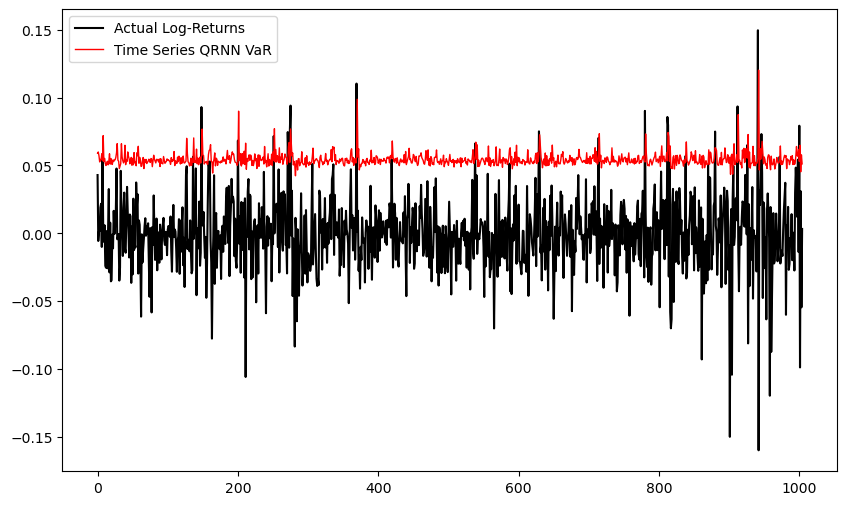

In [23]:
t = -np.array(df.iloc[:,0])
p = -np.array(y_pred)
plt.figure(figsize=(10,6))
plt.plot(range(len(t)) , t , 
            color='k',
            label = "Actual Log-Returns")
plt.plot(range(len(t)) , p , 
         color='r', 
         linewidth=1,
         label = "Time Series QRNN VaR")

plt.legend()
plt.show()

## Multi-Sources QRNN: meta-model fusion

In [24]:
news_pred = pd.read_csv('news_pred.csv', index_col=0)
news_pred_index = pd.to_datetime(news_pred.index)
news_pred.index = news_pred_index
news_pred.head(20)

,y_pred
date,
2015-01-05,-0.047514
2015-01-09,-0.048089
2015-01-12,-0.073606
2015-01-14,-0.060161
2015-01-15,-0.049767
2015-01-16,-0.048741
2015-01-20,-0.047431
2015-01-21,-0.080404
2015-01-22,-0.048905


In [25]:
y_pred = pd.DataFrame(y_pred, columns = ['y_pred1'])
pred = y_pred.join(news_pred, how='left')
pred.head(10)


,y_pred1,y_pred
Date,,
2015-01-05,-0.059079,-0.047514
2015-01-06,-0.059925,NaN
2015-01-07,-0.057172,NaN
2015-01-08,-0.052645,NaN
2015-01-09,-0.054377,-0.048089
2015-01-12,-0.054439,-0.073606
2015-01-13,-0.058624,NaN
2015-01-14,-0.053494,-0.060161
2015-01-15,-0.072012,-0.049767


In [26]:
#pred['y_pred'].fillna(pred['y_pred1'], inplace=True)
pred['y_pred'].fillna(method='ffill', inplace=True)
pred.head(10)

,y_pred1,y_pred
Date,,
2015-01-05,-0.059079,-0.047514
2015-01-06,-0.059925,-0.047514
2015-01-07,-0.057172,-0.047514
2015-01-08,-0.052645,-0.047514
2015-01-09,-0.054377,-0.048089
2015-01-12,-0.054439,-0.073606
2015-01-13,-0.058624,-0.073606
2015-01-14,-0.053494,-0.060161
2015-01-15,-0.072012,-0.049767


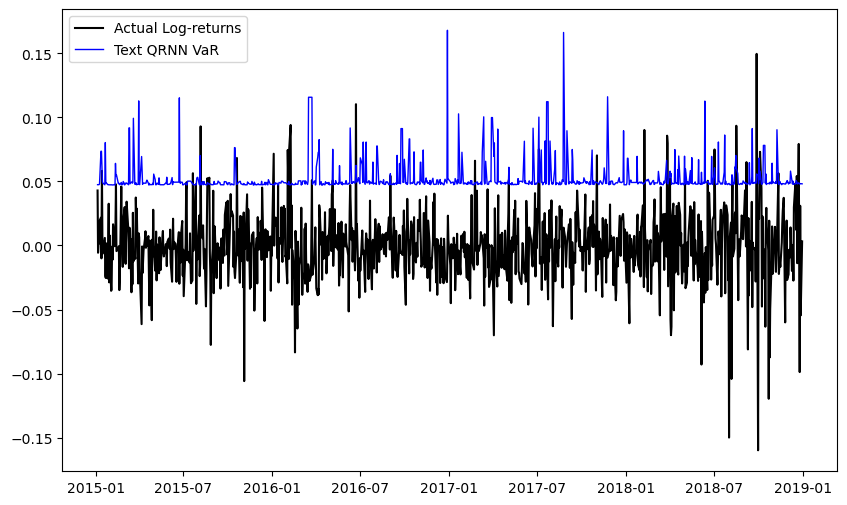

In [28]:
true = -np.array(df.iloc[:,0])
text = -np.array(pred.iloc[:,1])
plt.figure(figsize=(10,6))
plt.plot(df.index , true , 
            color='k',
            label = "Actual Log-returns")
plt.plot(df.index , text , 
         color='b', 
         linewidth=1,
         label = "Text QRNN VaR")
plt.legend()
plt.show()

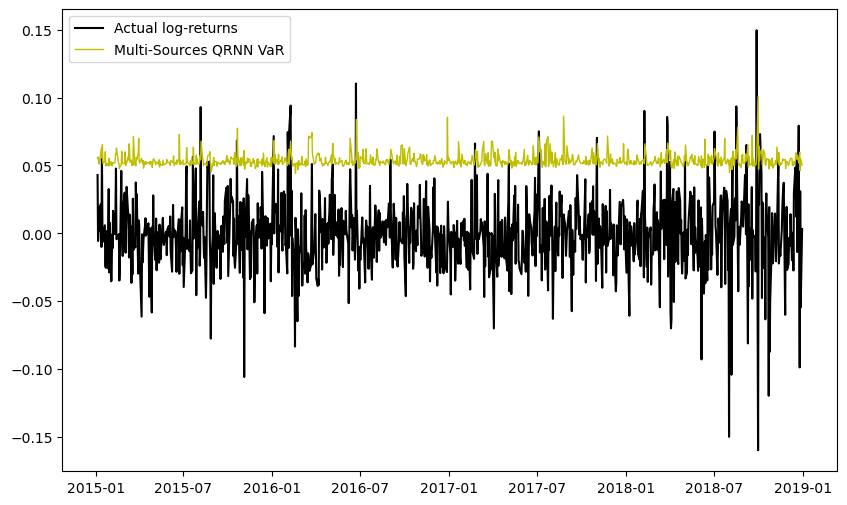

In [29]:
true = -np.array(df.iloc[:,0])
multi = -(0.3*pred.iloc[:,1]+0.7*pred.iloc[:,0])
plt.figure(figsize=(10,6))
plt.plot(df.index , true , 
            color='k',
            label = "Actual log-returns")
plt.plot(df.index , multi , 
         color='y', 
         linewidth=1,
         label = "Multi-Sources QRNN VaR")

plt.legend()
plt.show()

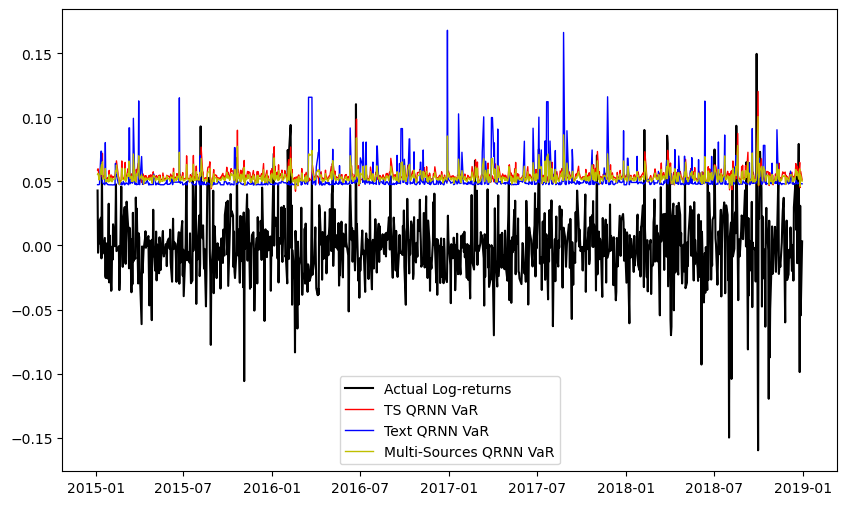

In [31]:
true = -np.array(df.iloc[:,0])
ts = -np.array(pred.iloc[:,0])
text = -np.array(pred.iloc[:,1])
multi = -(0.3*pred.iloc[:,1]+0.7*pred.iloc[:,0])
plt.figure(figsize=(10,6))
plt.plot(df.index , true , 
            color='k',
            label = "Actual Log-returns")
plt.plot(df.index , ts , 
         color='r', 
         linewidth=1,
         label = "TS QRNN VaR")
plt.plot(df.index , text , 
         color='b', 
         linewidth=1,
         label = "Text QRNN VaR")
plt.plot(df.index , multi , 
         color='y', 
         linewidth=1,
         label = "Multi-Sources QRNN VaR")

plt.legend()
plt.show()

### Out-of-sample observed Proportion of exceptions (Text QRNN)

In [32]:
np.mean(df_test.iloc[:,0] < pred.iloc[len(df_train):,1])

0.055776892430278883

### Fusion model and Observed Proportion of exceptions: MS QRNN

In [173]:
def quantile_loss(q):
    def ql(y_true , y_pred): 
        e = y_true - y_pred
        #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
        loss = K.mean(K.maximum(q*e , (q-1)*e)) 
        return loss

    return ql

q = 0.05
T = len(df_train)
N = len(df)
results = []

y_pred = []

y_prediction = []
for nseed in range(1, 101):
    seed = nseed
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    nn_reg = keras.Sequential()
    nn_reg.add(keras.layers.Dropout(0.2))
    nn_reg.add(keras.layers.Dense(2, input_dim = 2, activation='sigmoid', kernel_regularizer=l2(0)))
    nn_reg.add(keras.layers.Dense(1, activation='linear'))
    #nn_reg.summary()
                                    
    # compile neural network
    nn_reg.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.1), loss=quantile_loss(q))   
                                        
    x_t = pred[:T].to_numpy()
    y_t = df.iloc[:T, 0].to_numpy()                         
    model = nn_reg.fit(x_t, y_t, epochs = 100, verbose = 0)
    x_test = pred[T:].to_numpy()
    y_test = df.iloc[T:, 0]

    predictions = nn_reg.predict(x_test) 
    predictions = predictions.tolist()
    predictions = [item for sublist in predictions for item in sublist]
    y_prediction.append(predictions)
        
y_pred = [sum(elements) / len(y_prediction) for elements in zip(*y_prediction)]   
y_true = df_test.iloc[:,0].to_numpy()
err = y_true - y_pred 
loss =  K.mean(K.maximum(q*err, (q-1)*err))
exceptions = np.mean(y_true < y_pred)
results = []
results.append([loss, exceptions]) 
results  

8/8 [==============================] - 0s 1ms/step


[[<tf.Tensor: shape=(), dtype=float64, numpy=0.003950235023602115>,
  0.04780876494023904]]

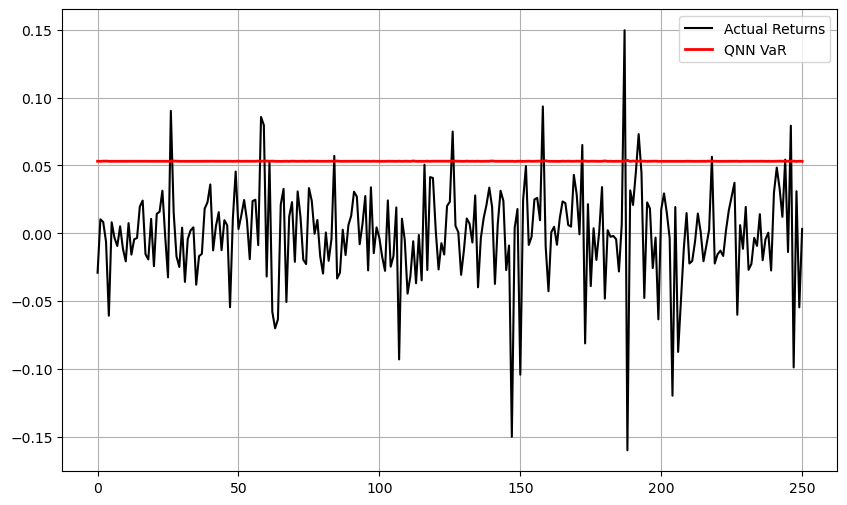

In [174]:
t = -y_true
p = -np.array(y_pred)
plt.figure(figsize=(10,6))
plt.plot(range(len(y_true)) , t , 
            color='k',
            label = "Actual Returns")
plt.plot(range(len(y_pred)) , p , 
         color='r', 
         linewidth=2,
         label = "QNN VaR")

plt.legend()
plt.grid()
plt.show()

In [ ]:
y_true = df_test.iloc[:,0].to_numpy()
err = y_true - y_pred 
loss =  K.mean(K.maximum(q*err, (q-1)*err))
exceptions = np.mean(y_true < y_pred)
results = []
results.append([str([0.01, 0, 0.1]), str([1, 3, 1, 2]), loss, exceptions]) 
results

## CAViaR

### Symmetric Absolute Value

In [18]:
from scipy.optimize import minimize
def CAViaR(beta, ret, q):
    VaR = []
    VaR.append(np.quantile(ret, q))
    for n in range(len(ret)-1):
        VaR.append(beta[0]+beta[1]*VaR[n]+beta[2]*abs(ret[n]))
    e = ret - VaR
    #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
    loss = np.mean(K.maximum(q*e , (q-1)*e)) 
    return loss

# Generazione di un punto di partenza casuale
initial_guess = [0.5, 0.5, -0.1]

q = 0.05
ret = df_train.iloc[:, 0].values
# Minimizzazione della funzione con l'algoritmo Nelder-Mead
result = minimize(CAViaR, initial_guess,args=(ret, q), method='nelder-mead')
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.0027544439975546293
             x: [-1.102e-02  5.838e-01 -3.005e-01]
           nit: 208
          nfev: 369
 final_simplex: (array([[-1.102e-02,  5.838e-01, -3.005e-01],
                       [-1.102e-02,  5.839e-01, -3.005e-01],
                       [-1.102e-02,  5.838e-01, -3.005e-01],
                       [-1.102e-02,  5.837e-01, -3.005e-01]]), array([ 2.754e-03,  2.754e-03,  2.754e-03,  2.754e-03]))

In [89]:
VaR_train = []
q = 0.05
ret = df_train.iloc[:, 0].values
beta = [-0.01102167,  0.5838374 , -0.30049158]
VaR_train.append(np.quantile(ret, q))
for n in range(len(ret)-1):
        VaR_train.append(beta[0] + beta[1] * VaR_train[n] + beta[2] * abs(ret[n]))

### CAViaR Symmetric: out-of sample observed proportions of exceptions 

In [91]:
VaR = []
q = 0.05
ret_train = df_train.iloc[:, 0].values
ret = df_test.iloc[:, 0].values
beta = [-0.01102167,  0.5838374 , -0.30049158]
VaR1 = beta[0] + beta[1] * VaR_train[len(VaR_train)-1] + beta[2] * abs(ret_train[len(ret_train)-1])
VaR.append(VaR1)
for n in range(len(ret)-1):
        VaR.append(beta[0] + beta[1] * VaR[n] + beta[2] * abs(ret[n]))
np.mean(ret < VaR)


0.06374501992031872

### Asymmetric Slope

In [49]:
ret = df_train.iloc[:, 0]
ret = pd.DataFrame(ret)
ret['xpos'] = K.maximum(ret,0).numpy()
ret['xneg'] = -K.minimum(ret['returns'],0).numpy()
ret

,returns,xpos,xneg
Date,,,
2015-01-05,-0.042950,0.000000,0.042950
2015-01-06,0.005648,0.005648,-0.000000
2015-01-07,-0.001563,0.000000,0.001563
2015-01-08,-0.001566,0.000000,0.001566
2015-01-09,-0.018981,0.000000,0.018981
...,...,...,...
2017-12-22,-0.019670,0.000000,0.019670
2017-12-26,-0.024624,0.000000,0.024624
2017-12-27,-0.017968,0.000000,0.017968


In [31]:
from scipy.optimize import minimize
def CAViaR(beta, ret, q):
    VaR = []
    VaR.append(np.quantile(ret['returns'], q))
    for n in range(len(ret)-1):
        VaR.append(beta[0] + beta[1] * VaR[n] + beta[2] * ret.iloc[n,1] + beta[3] * ret.iloc[n,2])
    e = ret['returns'] - VaR
    #if e > 0 then qe > (q-1)e; if e < 0 then qe < (q-1)e
    loss = np.mean(K.maximum(q*e , (q-1)*e))
    return loss

# Generazione di un punto di partenza casuale
initial_guess = [0.7, 0.7, 0.7, 0.7]

q = 0.05
ret = ret
# Minimizzazione della funzione con l'algoritmo Nelder-Mead
result = minimize(CAViaR, initial_guess,args=(ret, q), method='BFGS')
result

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.002708164468846866
        x: [-4.625e-02 -1.790e-01  3.554e-01 -2.889e-01]
      nit: 43
      jac: [ 3.438e-04  2.364e-05  6.616e-05 -6.206e-06]
 hess_inv: [[ 3.269e-04  5.481e-03 -1.409e-03 -1.814e-03]
            [ 5.481e-03  1.083e-01 -2.348e-02 -1.284e-02]
            [-1.409e-03 -2.348e-02  6.645e-03  8.401e-03]
            [-1.814e-03 -1.284e-02  8.401e-03  1.158e-01]]
     nfev: 737
     njev: 145

In [53]:
VaR_train = []
q = 0.05
ret = ret
beta = [-0.08287176, -0.99710755,  0.0341517 ,  0.01118014]
VaR_train.append(np.quantile(ret['returns'], q))
for n in range(len(ret)-1):
        VaR_train.append(beta[0] + beta[1] * VaR_train[n] + beta[2] * ret.iloc[n,1] + beta[3] * ret.iloc[n,2])

In [54]:
ret_train = df_train.iloc[:, 0]
ret_train = pd.DataFrame(ret_train)
ret_train['xpos'] = K.maximum(ret_train,0).numpy()
ret_train['xneg'] = -K.minimum(ret_train['returns'],0).numpy()
ret_train

,returns,xpos,xneg
Date,,,
2015-01-05,-0.042950,0.000000,0.042950
2015-01-06,0.005648,0.005648,-0.000000
2015-01-07,-0.001563,0.000000,0.001563
2015-01-08,-0.001566,0.000000,0.001566
2015-01-09,-0.018981,0.000000,0.018981
...,...,...,...
2017-12-22,-0.019670,0.000000,0.019670
2017-12-26,-0.024624,0.000000,0.024624
2017-12-27,-0.017968,0.000000,0.017968


In [55]:
ret = df_test.iloc[:, 0]
ret = pd.DataFrame(ret)
ret['xpos'] = K.maximum(ret,0).numpy()
ret['xneg'] = -K.minimum(ret['returns'],0).numpy()
ret

,returns,xpos,xneg
Date,,,
2018-01-02,0.029058,0.029058,-0.000000
2018-01-03,-0.010286,0.000000,0.010286
2018-01-04,-0.008325,0.000000,0.008325
2018-01-05,0.006210,0.006210,-0.000000
2018-01-08,0.060755,0.060755,-0.000000
...,...,...,...
2018-12-24,-0.079305,0.000000,0.079305
2018-12-26,0.098877,0.098877,-0.000000
2018-12-27,-0.031020,0.000000,0.031020


### CAViaR Asymmetric: out-of sample observed proportions of exceptions 

In [56]:
VaR = []
q = 0.05
ret_train = ret_train
ret = ret
beta = [-0.08287176, -0.99710755,  0.0341517 ,  0.01118014]
VaR1 = beta[0] + beta[1] * VaR_train[len(VaR_train)-1] + beta[2] * ret_train.iloc[len(ret_train)-1,1] + beta[3] * ret_train.iloc[len(ret_train)-1,2]
VaR.append(VaR1)
for n in range(len(ret)-1):
        VaR.append(beta[0] + beta[1] * VaR[n] + beta[2] * ret.iloc[n,1] + beta[3] * ret.iloc[n,2])
np.mean(ret['returns'] < VaR)

0.07171314741035857